In [1]:
# reload packages
%load_ext autoreload
%autoreload 2

### Choose GPU

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=''#0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=''#0


In [3]:
import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if len(gpu_devices)>0:
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
print(gpu_devices)
tf.keras.backend.clear_session()

[]


### Load packages

In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
from IPython import display
import pandas as pd
import umap
import copy
import os, tempfile
import tensorflow_addons as tfa
import pickle


/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


### parameters

In [5]:
dataset = "cifar10"
labels_per_class = 64 # 'full'
n_latent_dims = 1024
confidence_threshold = 0.0 # minimum confidence to include in UMAP graph for learned metric
learned_metric = True # whether to use a learned metric, or Euclidean distance between datapoints

augmented = True #
min_dist= 0.001 # min_dist parameter for UMAP
negative_sample_rate = 5 # how many negative samples per positive sample 
batch_size = 128 # batch size 
optimizer = tf.keras.optimizers.Adam(1e-3) # the optimizer to train
optimizer = tfa.optimizers.MovingAverage(optimizer)
label_smoothing = 0.2 # how much label smoothing to apply to categorical crossentropy
max_umap_iterations = 500 # how many times, maximum, to recompute UMAP
max_epochs_per_graph = 10 # how many epochs maximum each graph trains for (without early stopping)
graph_patience = 10 # how many times without improvement to train a new graph
min_graph_delta = 0.0025 # minimum improvement on validation acc to consider an improvement for training

In [6]:
from datetime import datetime

datestring = datetime.now().strftime("%Y_%m_%d_%H_%M_%S_%f")
datestring = (
    str(dataset)
    + "_"
    + str(confidence_threshold)
    + "_"
    + str(labels_per_class)
    + "____"
    + datestring 
    + '_umap_augmented'
)
print(datestring)

cifar10_0.0_64____2020_08_27_00_44_18_325812_umap_augmented


#### Load dataset

In [7]:
from tfumap.semisupervised_keras import load_dataset

In [8]:
(
    X_train,
    X_test,
    X_labeled,
    Y_labeled,
    Y_masked,
    X_valid,
    Y_train,
    Y_test,
    Y_valid,
    Y_valid_one_hot,
    Y_labeled_one_hot,
    num_classes,
    dims
) = load_dataset(dataset, labels_per_class)

### load architecture

In [9]:
from tfumap.semisupervised_keras import load_architecture

In [10]:
encoder, classifier, embedder = load_architecture(dataset, n_latent_dims)

### load pretrained weights

In [11]:
from tfumap.semisupervised_keras import load_pretrained_weights

In [12]:
encoder, classifier = load_pretrained_weights(dataset, augmented, labels_per_class, encoder, classifier)

W0827 00:44:20.783378 140530947594048 base.py:272] Inconsistent references when loading the checkpoint into this object graph. Either the Trackable object references in the Python program have changed in an incompatible way, or the checkpoint was generated in an incompatible program.

Two checkpoint references resolved to different objects (<tensorflow_addons.layers.wrappers.WeightNormalization object at 0x7fcf280895c0> and <tensorflow.python.keras.layers.advanced_activations.LeakyReLU object at 0x7fcf28089a58>).
W0827 00:44:20.785661 140530947594048 base.py:272] Inconsistent references when loading the checkpoint into this object graph. Either the Trackable object references in the Python program have changed in an incompatible way, or the checkpoint was generated in an incompatible program.

Two checkpoint references resolved to different objects (<tensorflow_addons.layers.wrappers.WeightNormalization object at 0x7fcf28096b70> and <tensorflow.python.keras.layers.advanced_activations.

W0827 00:44:20.883909 140530947594048 base.py:272] Inconsistent references when loading the checkpoint into this object graph. Either the Trackable object references in the Python program have changed in an incompatible way, or the checkpoint was generated in an incompatible program.

Two checkpoint references resolved to different objects (<tensorflow_addons.layers.wrappers.WeightNormalization object at 0x7fcf2814fd68> and <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fcf2821c0b8>).
W0827 00:44:20.886520 140530947594048 base.py:272] Inconsistent references when loading the checkpoint into this object graph. Either the Trackable object references in the Python program have changed in an incompatible way, or the checkpoint was generated in an incompatible program.

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fcf2821c0b8> and <tensorflow.python.keras.layers.adv

#### compute pretrained accuracy

In [13]:
# test current acc
pretrained_predictions = classifier.predict(encoder.predict(X_test, verbose=True), verbose=True)
pretrained_confidence = np.argmax(pretrained_predictions, axis=1)
pretrained_predictions = np.argmax(pretrained_predictions, axis=1)
pretrained_acc = np.mean(pretrained_predictions == Y_test)
print('pretrained acc: {}'.format(pretrained_acc))

313/313 [==============================] - 0s 1ms/step
pretrained acc: 0.5993


In [14]:
# test current acc
train_predictions = classifier.predict(encoder.predict(X_train, verbose=True), verbose=True)
train_confidence = np.max(train_predictions, axis=1)
train_predictions = np.argmax(train_predictions, axis=1)

1250/1250 [==============================] - 2s 1ms/step


In [15]:
encoder_layers = encoder.layers

In [16]:
encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1a (WeightNormalization) (None, 32, 32, 128)       7297      
_________________________________________________________________
bn1a (BatchNormalization)    (None, 32, 32, 128)       512       
_________________________________________________________________
lrelu1a (LeakyReLU)          (None, 32, 32, 128)       0         
_________________________________________________________________
conv1b (WeightNormalization) (None, 32, 32, 128)       295297    
_________________________________________________________________
bn1b (BatchNormalization)    (None, 32, 32, 128)       512       
_________________________________________________________________
lrelu1b (LeakyReLU)          (None, 32, 32, 128)       0         
_________________________________________________________________
conv1c (WeightNormalization) (None, 32, 32, 128)       2

In [17]:
from sklearn.decomposition import PCA

In [18]:
from umap import UMAP

z 33024
UMAP(dens_frac=0.0, dens_lambda=0.0, low_memory=True, verbose=True)
Construct fuzzy simplicial set
Thu Aug 27 00:57:07 2020 Finding Nearest Neighbors
Thu Aug 27 00:57:07 2020 Building RP forest with 15 trees
Thu Aug 27 00:57:08 2020 parallel NN descent for 15 iterations
	 0  /  15
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
Thu Aug 27 00:57:12 2020 Finished Nearest Neighbor Search
Thu Aug 27 00:57:15 2020 Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Thu Aug 27 00:57:57 2020 Finished embedding


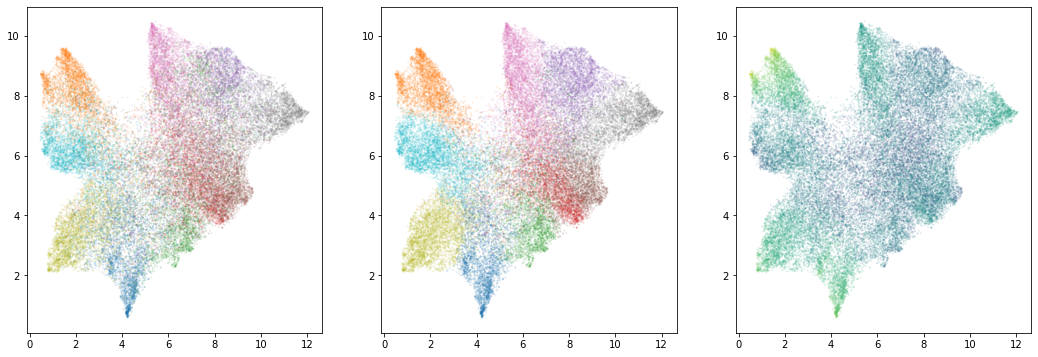

conv3c 32896
UMAP(dens_frac=0.0, dens_lambda=0.0, low_memory=True, verbose=True)
Construct fuzzy simplicial set
Thu Aug 27 00:59:38 2020 Finding Nearest Neighbors
Thu Aug 27 00:59:39 2020 Building RP forest with 15 trees
Thu Aug 27 00:59:42 2020 parallel NN descent for 15 iterations
	 0  /  15
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	 5  /  15
	 6  /  15
Thu Aug 27 00:59:47 2020 Finished Nearest Neighbor Search
Thu Aug 27 00:59:47 2020 Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Thu Aug 27 01:00:16 2020 Finished embedding


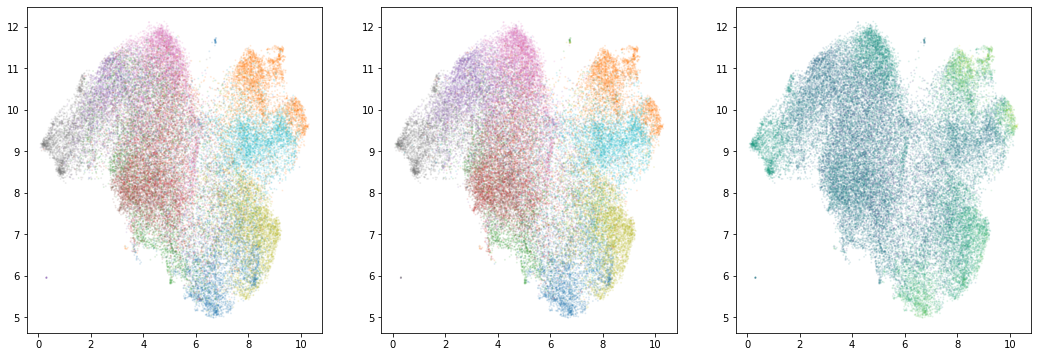

conv3b 131328
UMAP(dens_frac=0.0, dens_lambda=0.0, low_memory=True, verbose=True)
Construct fuzzy simplicial set
Thu Aug 27 01:01:59 2020 Finding Nearest Neighbors
Thu Aug 27 01:01:59 2020 Building RP forest with 15 trees
Thu Aug 27 01:02:06 2020 parallel NN descent for 15 iterations
	 0  /  15
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	 5  /  15
	 6  /  15
Thu Aug 27 01:02:13 2020 Finished Nearest Neighbor Search
Thu Aug 27 01:02:14 2020 Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Thu Aug 27 01:02:42 2020 Finished embedding


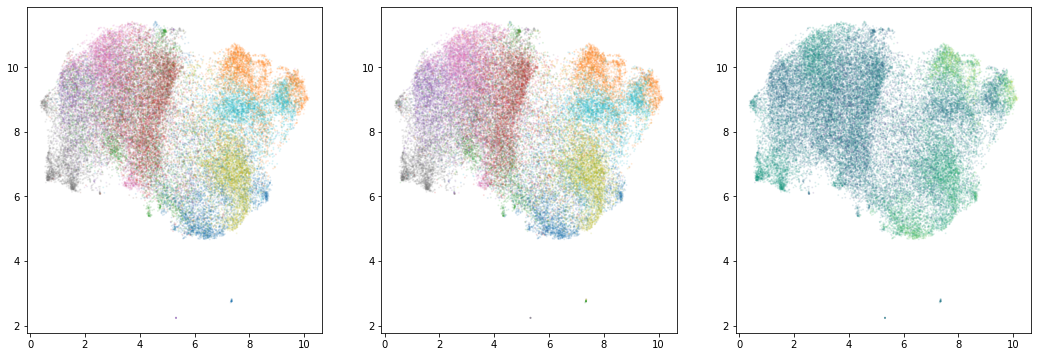

conv3a 1180160
UMAP(dens_frac=0.0, dens_lambda=0.0, low_memory=True, verbose=True)
Construct fuzzy simplicial set
Thu Aug 27 01:04:25 2020 Finding Nearest Neighbors
Thu Aug 27 01:04:25 2020 Building RP forest with 15 trees
Thu Aug 27 01:04:36 2020 parallel NN descent for 15 iterations
	 0  /  15
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	 5  /  15
	 6  /  15
Thu Aug 27 01:04:50 2020 Finished Nearest Neighbor Search
Thu Aug 27 01:04:51 2020 Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Thu Aug 27 01:05:37 2020 Finished embedding


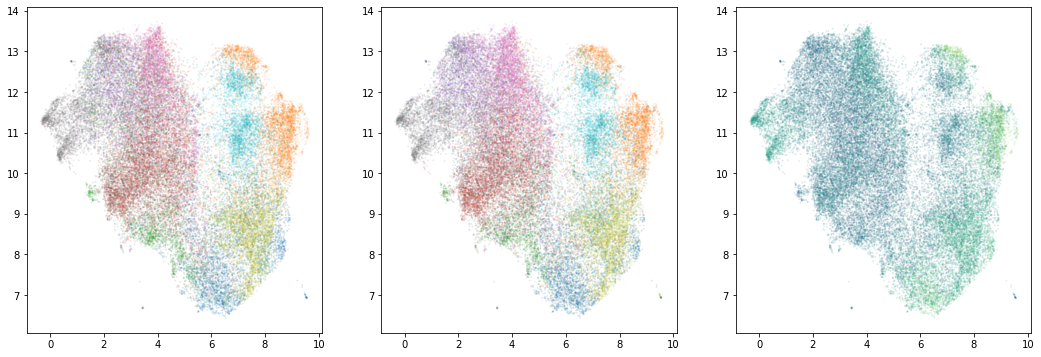

conv2c 590080
conv2b 590080
conv2a 295168
conv1c 147584
conv1b 147584


In [24]:
for layer in encoder_layers[::-1]:
    layer_name = layer.name
    n_trainable_weights = np.sum(
        [np.product(i.shape) for i in layer._trainable_weights]
    )
    if n_trainable_weights > 10000:
        print(layer_name, n_trainable_weights)
        enc_model = tf.keras.models.Model(
            encoder.input, [encoder.get_layer(name=layer_name).get_output_at(0)],
        )
        layer_z = enc_model.predict(X_train, batch_size=32)
        layer_z = layer_z.reshape(len(layer_z), np.product(layer_z.shape[1:]))
        if np.shape(layer_z)[1] > 20000:
            continue
        # if np.shape(layer_z)[1] > 5000:
        #    # get the first 5000 PCs
        #    layer_z = PCA(n_components=5000).fit_transform(layer_z)

        layer_embedder = UMAP(verbose=True, low_memory=True)
        layer_embedding = layer_embedder.fit_transform(layer_z)

        fig, axs = plt.subplots(ncols=3, figsize=(18, 6))
        axs[0].scatter(
            layer_embedding[:, 0],
            layer_embedding[:, 1],
            c=Y_train.flatten(),
            s=1,
            alpha=0.1,
            cmap=plt.cm.tab10,
        )
        axs[1].scatter(
            layer_embedding[:, 0],
            layer_embedding[:, 1],
            c=train_predictions,
            s=1,
            alpha=0.1,
            cmap=plt.cm.tab10,
        )
        axs[2].scatter(
            layer_embedding[:, 0],
            layer_embedding[:, 1],
            c=train_confidence,
            s=1,
            alpha=0.1,
            cmap=plt.cm.viridis,
        )
        plt.show()

In [22]:
np.shape(layer_z)[1]

131072

In [20]:
train_confidence

array([3.319945 , 3.130224 , 2.9144895, ..., 2.7775972, 3.6643002,
       1.5023274], dtype=float32)